# LVM Guide Star Catalog using the new library

In [1]:
import lvmguiding
import numpy as np
import os
import matplotlib.pyplot as plt
import time
from astropy.coordinates import SkyCoord
from importlib import reload
from matplotlib.colors import LogNorm

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
lvmguiding.cat_full.shape

(157645865,)

## Creating the pointing list

In [3]:
!pwd

/home/haeberle/Projects/LVM/LVM_Guide_Stars/lvmguiding


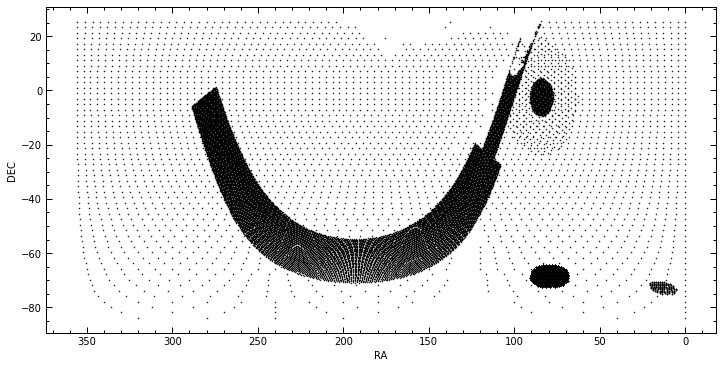

In [4]:
if False: #Old way of creating the pointing list:
    pointing_list = []

    counter = 0
    ra_list =[]
    dec_list=[]
    for ra in np.arange(5,355,30):
        for dec in np.arange(-85,85,20):
            c = SkyCoord(frame='icrs',ra=ra, dec=dec,unit='deg')
            pointing_list.append(c)
            ra_list.append(ra)
            dec_list.append(dec)
    #pointing_list=pointing_list[:10]

    indices = np.array(range(len(pointing_list)))

    output = np.stack((indices,ra_list,dec_list),axis=1)

    os.system("mkdir guide_star_search_results")
    filename = "guide_star_search_results/pointing_list"

    #pointing_list = pointing_list[[1,4,34,56,70,100]]
    if True: np.savetxt(filename,output,fmt="%10.6f")

    #pointing_list = pointing_list[::50]

if True: #new way of creating the pointing list
    from astropy.io import fits
    with fits.open("lvmsurveysim_hz_1000.fits") as hdul:
        my_data = hdul[1].data

    my_data = my_data[my_data["ra"]>-500]

    ra_list = my_data["ra"]
    dec_list = my_data["dec"]

    indices = np.array(range(len(ra_list)))




    pointing_list = []

    for index in indices:
        ra = ra_list[index]
        dec = dec_list[index]

        c = SkyCoord(frame='icrs',ra=ra, dec=dec,unit='deg')
        pointing_list.append(c)

    output = np.stack((indices,ra_list,dec_list),axis=1)


    filename = "guide_star_search_results/pointing_list"

    #pointing_list = pointing_list[[1,4,34,56,70,100]]
    if False:
        np.savetxt(filename,output,fmt="%10.6f")

fig,ax = plt.subplots(figsize=(12,6))
ax.plot(ra_list,dec_list,"k.",ms=1)
ax.set_xlabel("RA")
ax.set_ylabel("DEC") 
ax.invert_xaxis()

    
pointing_touple_list = []
for index,c in enumerate(pointing_list):
    pointing_touple_list.append((index,c))

## Sequential work on the pointing list

In [5]:
#c = SkyCoord(frame="galactic", l=280, b=0,unit='deg'
#ras,decs,dd_x_mm,dd_y_mm,chip_xxs,chip_yys,mags,culled_cat = find_guide_stars2(c,pa=0,plotflag=True,recycled_cat=culled_cat)

if False:
    for index,c in enumerate(pointing_list):
        print("Analyzing pointing {} of {} (ra: {} dec: {})".format(index+1,len(pointing_list),c.ra.deg,c.dec.deg))
        #c = SkyCoord(frame="galactic", l=280, b=0,unit='deg')
        #print(c)
        for pa in [0,60,120,180,240,300]:
            print("PA: ",pa)
            if pa==0:
                culled_cat=cat_full
            ras,decs,dd_x_mm,dd_y_mm,chip_xxs,chip_yys,mags,culled_cat = find_guide_stars2(c,pa=pa,plotflag=False,recycled_cat=culled_cat)    

            output = np.stack((ras,decs,dd_x_mm,dd_y_mm,chip_xxs,chip_yys,mags))
            filename = "guide_star_search_results/guide_stars_{:06d}_pa_{:03d}".format(index,pa)
            np.savetxt(filename,output,fmt="%10.6f")

        
#ras,decs,dd_x_mm,dd_y_mm,chip_xxs,chip_yys,mags,culled_cat = find_guide_stars2(c,pa=60,plotflag=True,recycled_cat=culled_cat)
#ras,decs,dd_x_mm,dd_y_mm,chip_xxs,chip_yys,mags, culled_cat = find_guide_stars2(c,pa=120,plotflag=True,recycled_cat=culled_cat)
#ras,decs,dd_x_mm,dd_y_mm,chip_xxs,chip_yys,culled_cat = find_guide_stars2(c,pa=180,plotflag=True,recycled_cat=culled_cat)
#ras,decs,dd_x_mm,dd_y_mm,chip_xxs,chip_yys,culled_cat = find_guide_stars2(c,pa=240,plotflag=True,recycled_cat=culled_cat)
#ras,decs,dd_x_mm,dd_y_mm,chip_xxs,chip_yys,culled_cat = find_guide_stars2(c,pa=300,plotflag=True,recycled_cat=culled_cat)

## Paralellized work on the pointing list

In [6]:
if False: 
    
    from multiprocessing import Pool

    t00 = time.time()
    num_processors = 30#Create a pool of processors
    p=Pool(processes = num_processors)#get them to work in parallel
    output = p.map(lvmguiding.find_guide_stars_auto,[input_touple for input_touple in pointing_touple_list[:]])
    p.close()
    p.join()

    for o in output:
        print(o)

    t11 = time.time()

    print("Total execution time: {:.1f} s".format(t11-t00))

## Making some example plots

In [7]:
#What is going on at <SkyCoord (ICRS): (ra, dec) in deg
#    (80.01870621, -68.35233157)>

<SkyCoord (ICRS): (ra, dec) in deg
    (80.01870621, -68.35233157)>
PA:  0
Using the full cat for the first position
PA:  60
PA:  120
PA:  180
PA:  240
PA:  300


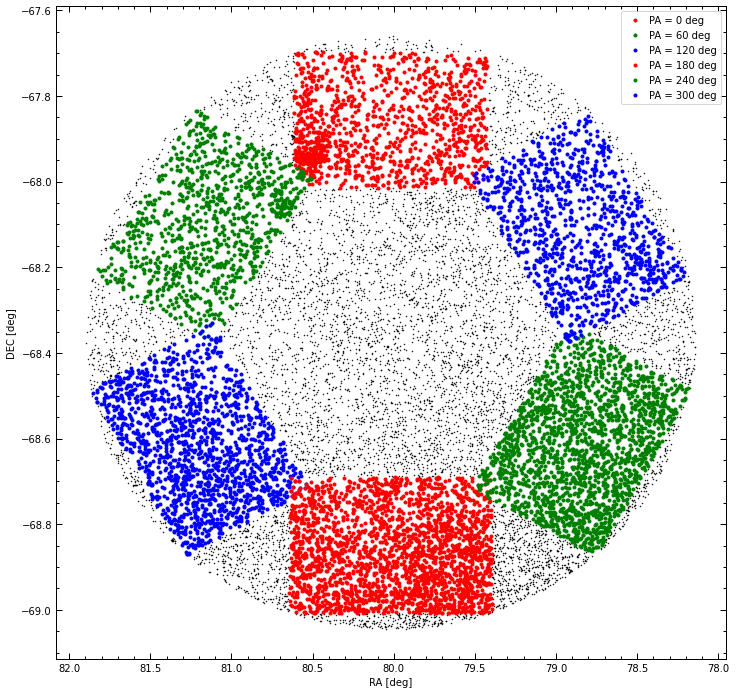

In [8]:
c = pointing_touple_list[50][1]
print(c)
color_array=["r","g","b","r","g","b"]


fig,ax = plt.subplots(figsize=(12,12))

for index,pa in enumerate([0,60,120,180,240,300]):
        print("PA: ",pa)
        if pa==0:
            print("Using the full cat for the first position")
            culled_cat=lvmguiding.cat_full
        ras,decs,dd_x_mm,dd_y_mm,chip_xxs,chip_yys,mags,culled_cat = lvmguiding.find_guide_stars(c,pa=pa,plotflag=False,recycled_cat=culled_cat)
        
        if pa==0:
            ax.plot(culled_cat["ra"],culled_cat["dec"],"k.",ms=1)
        ax.plot(ras,decs,".",c=color_array[index],label="PA = "+str(pa)+" deg")
        
ax.legend()

ax.set_xlabel("RA [deg]")
ax.set_ylabel("DEC [deg]")
ax.invert_xaxis()

#fig.savefig("/home/haeberle/exchange/lvm/report/position_angles.png",bbox_inches="tight",facecolor="w",edgecolor="w",dpi=200)

## Create a synthetic image

In [11]:
ras,decs,dd_x_mm,dd_y_mm,chip_xxs,chip_yys,mags,culled_cat = lvmguiding.find_guide_stars(c,pa=0,plotflag=False)

In [13]:
standard_instrument = lvmguiding.InstrumentParameters()

In [15]:
my_image = lvmguiding.make_synthetic_image(chip_x=chip_xxs,
                                           chip_y=chip_yys,
                                          gmag=mags,
                                          inst =standard_instrument,
                                          exp_time=5,
                                          seeing_arcsec=3.5,
                                          sky_flux=15)

1494 of 1494 stars are on the chip.
Nstars:  (1494,)


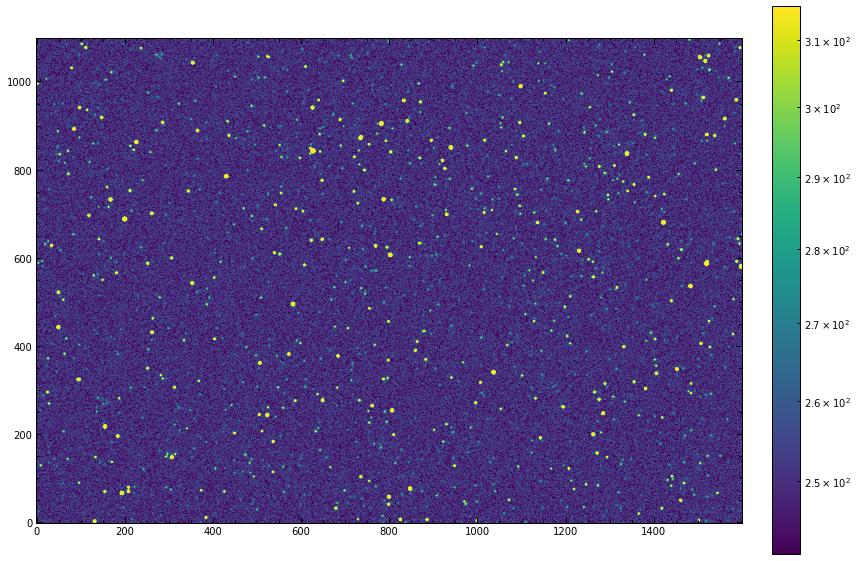

In [16]:
combined= my_image
fig,ax4 = plt.subplots(figsize=(12,8))

vmin4 = np.percentile(combined,25)
vmax4 = np.percentile(combined,99.5)

my_plot4 = ax4.imshow(combined,origin="lower",norm=LogNorm(vmin=np.max([vmin4,1]), vmax=vmax4))


#if np.sum(sn>5) < 10:
#    ax4.set_title("Combined (Bias + Readout Error + Noisy Background + Noisy Stars)\nBrightest star (red): gmag = {:.2f} ; F = {:.1f} e-/s\nPotentially saturated pixels (Ne- > 20000): {}\nWhite circle around all stars with S/N > 5 (N = {})".format(np.min(gmag),gaia_flux[np.argmin(gmag)],np.sum(combined>20000),np.sum(sn>5)))
#    ax4.plot(x_position[sn>5],y_position[sn>5],"o",ms=40,markerfacecolor="none",markeredgecolor="w",label="gmag < 12")
#else:
#    ax4.set_title("Combined (Bias + Readout Error + Noisy Background + Noisy Stars)\nPointing: {}  Texp: {} s\n{} of {} stars have a S/N > 5\nBrightest star (red): gmag = {:.2f} ; F = {:.1f} e-/s\nPotentially saturated pixels (Ne- > 20000): {}\n".format(pointing_string,exp_time,np.sum(sn>5),len(gmag),np.min(gmag),gaia_flux[np.argmin(gmag)],np.sum(combined>20000)))
#ax4.plot(x_position[np.argmin(gmag)],y_position[np.argmin(gmag)],"o",ms=20,markerfacecolor="none",markeredgecolor="r",label="gmag < 12")
plt.colorbar(my_plot4,ax=ax4,fraction=0.046, pad=0.04)
#plt.colorbar(my_plot4,ax=ax,fraction=0.046, pad=0.04)
#ax4.legend()

fig.tight_layout()

#filename = "/home/haeberle/exchange/lvm/report/pointing_"+pointing_string+"_{:d}ms.png".format(int(1000*exp_time))
#fig.suptitle()
#fig.savefig("/home/haeberle/exchange/lvm/report/example_crowded_field.png",dpi=200,bbox_inches="tight",edgecolor="white",facecolor="white")
#fig.savefig(filename,dpi=200,bbox_inches="tight",edgecolor="white",facecolor="white") 

In [ ]:
lvmifusim.__dict__